In [1]:
# Imports and Setup
import sys
import numpy as np
import pandas as pd
from pathlib import Path

sys.path.insert(0, str(Path("..") / "src"))

from utils import config
from utils.io import results_dir, save_json
from utils.plotting import plot_signal
from utils.load_dataset_ucr import load_raw_data, parse_ucr_filename

np.random.seed(config.RANDOM_SEED)

CANDIDATES = list(config.PINNED_RAW_FILES.keys())

MAX_POINTS_OVERVIEW = 8000

In [2]:
# Helpers

def expected_n_windows(n_points: int, window_size: int, stride: int) -> int:
    if n_points < window_size:
        return 0
    return 1 + (n_points - window_size) // stride


def load_raw_series_labels_meta(dataset_name: str):
    raw_file = config.PINNED_RAW_FILES[dataset_name]
    raw_path = config.ALL_RAW_DIR / raw_file
    if not raw_path.exists():
        raise FileNotFoundError

    meta = parse_ucr_filename(str(raw_path))
    meta.update({"dataset_name": dataset_name, "source_file": raw_file})

    series = load_raw_data(str(raw_path))
    series = np.asarray(series, dtype=float).reshape(-1)

    if not np.isfinite(series).all():
        raise ValueError

    labels = np.zeros(len(series), dtype=int)
    a0, a1 = int(meta["anomaly_start"]), int(meta["anomaly_end"])
    labels[a0:a1] = 1 

    return series, labels, meta


def summary_row(series: np.ndarray, labels: np.ndarray, meta: dict) -> dict:
    n = int(len(series))
    train_end = int(meta["train_end"])
    test_len = n - train_end

    a0, a1 = int(meta["anomaly_start"]), int(meta["anomaly_end"])
    anom_len = int(a1 - a0)

    w = int(config.WINDOW_SIZE)
    s = int(config.STRIDE)

    return {
        "dataset": meta["dataset_name"],
        "selected_in_config": meta["dataset_name"] in set(config.DATASETS),
        "source_file": meta["source_file"],
        "length": n,
        "train_end": train_end,
        "test_length": test_len,
        "anomaly_start": a0,
        "anomaly_end": a1,
        "anomaly_length": anom_len,
        "anomaly_%": float(labels.mean() * 100.0),
        "train_anomaly_points": int(labels[:train_end].sum()),
        "test_anomaly_points": int(labels[train_end:].sum()),
        "mean": float(np.mean(series)),
        "std": float(np.std(series)),
        "min": float(np.min(series)),
        "max": float(np.max(series)),
        "train_windows_expected": expected_n_windows(train_end, w, s),
        "test_windows_expected": expected_n_windows(test_len, w, s),
    }


def make_plots(dataset_name: str, series: np.ndarray, labels: np.ndarray, meta: dict, out_dir: Path):
    train_end = int(meta["train_end"])
    a0, a1 = int(meta["anomaly_start"]), int(meta["anomaly_end"])
    margin = int(config.PLOT_ZOOM_MARGIN)

    plot_signal(
        series,
        true_labels=labels,
        title=f"{dataset_name} | full | train_end={train_end} | anomaly=[{a0},{a1})",
        save_path=out_dir / "full_overview.png",
        show=True,
        max_points=MAX_POINTS_OVERVIEW,
    )

    z0 = max(0, a0 - margin)
    z1 = min(len(series), a1 + margin)

    plot_signal(
        series[z0:z1],
        true_labels=labels[z0:z1],
        title=f"{dataset_name} | zoom | [{z0},{z1}) | anomaly=[{a0},{a1})",
        save_path=out_dir / "zoom_anomaly.png",
        show=True,
        x_offset=z0,
    )

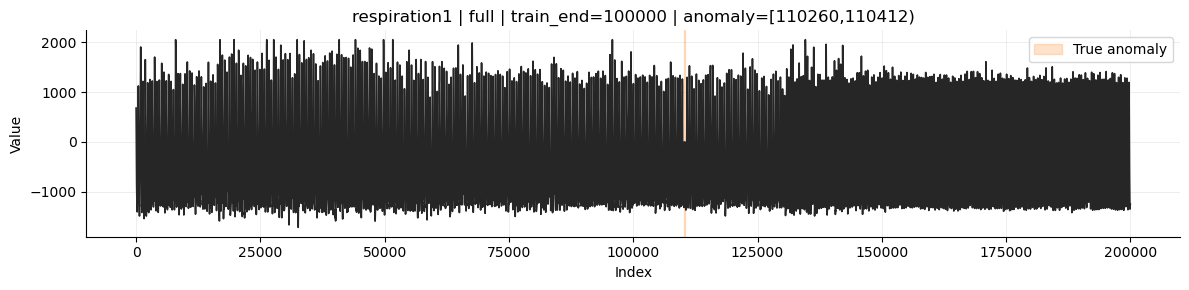

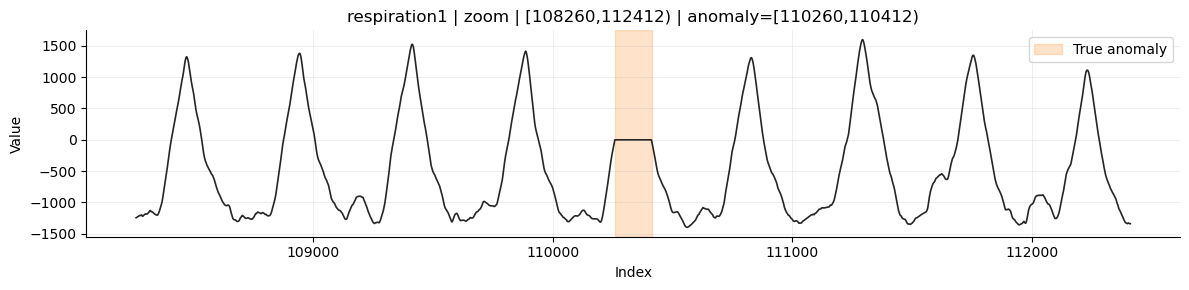

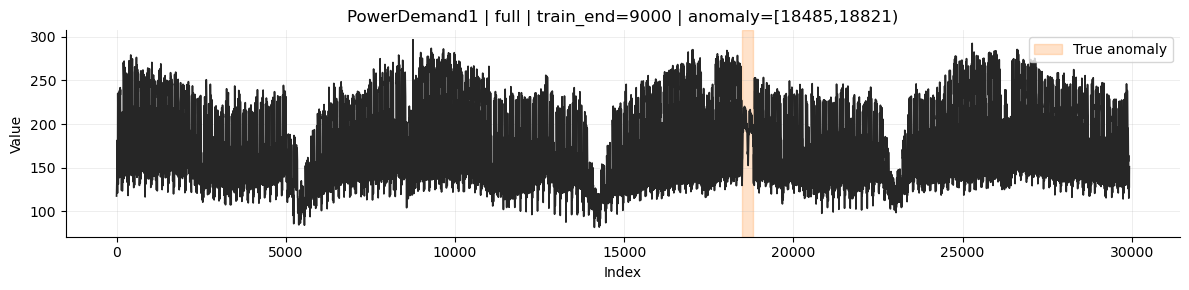

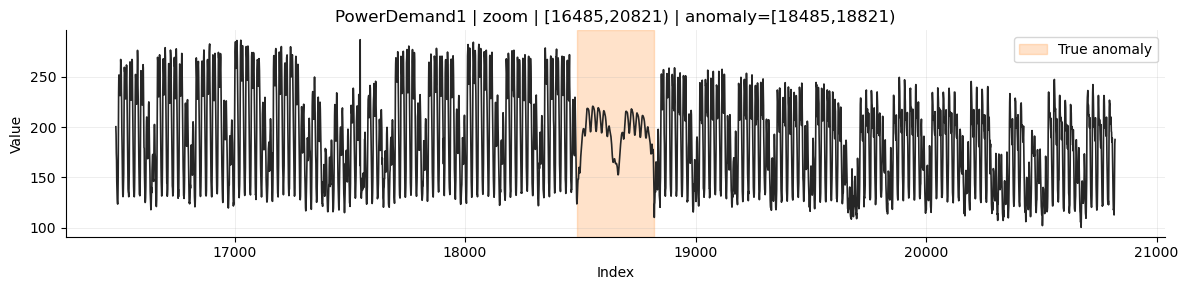

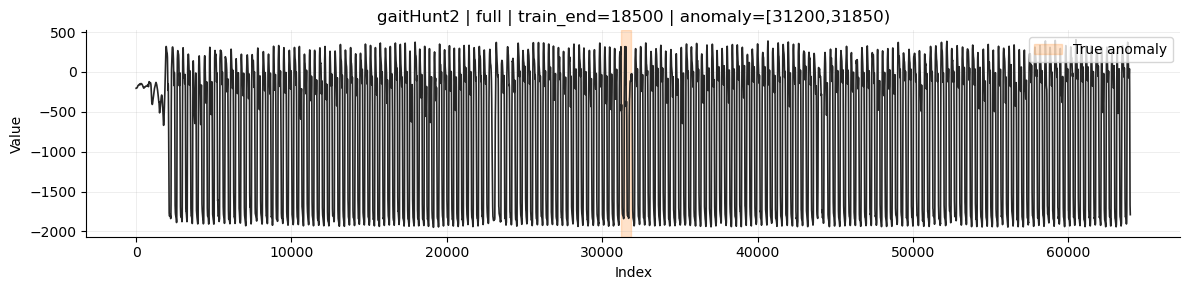

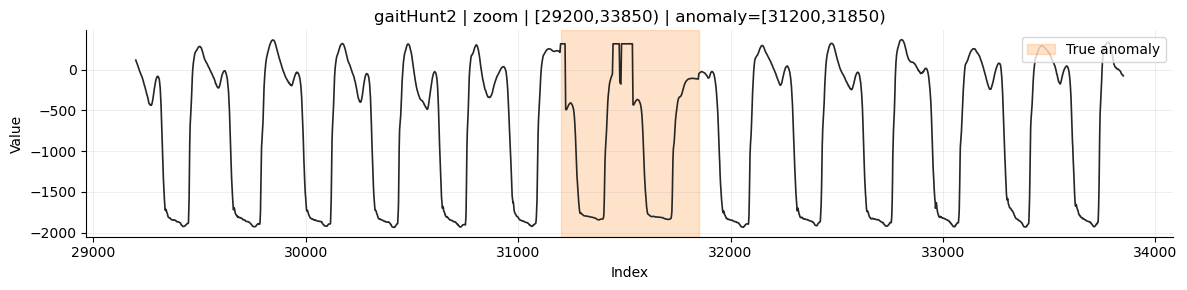

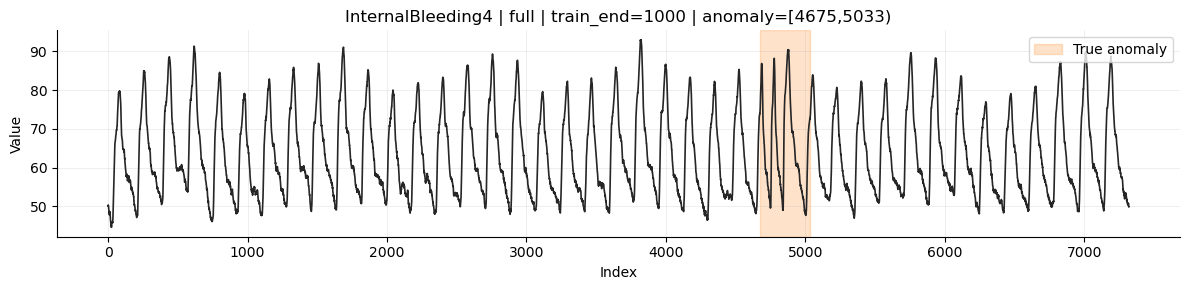

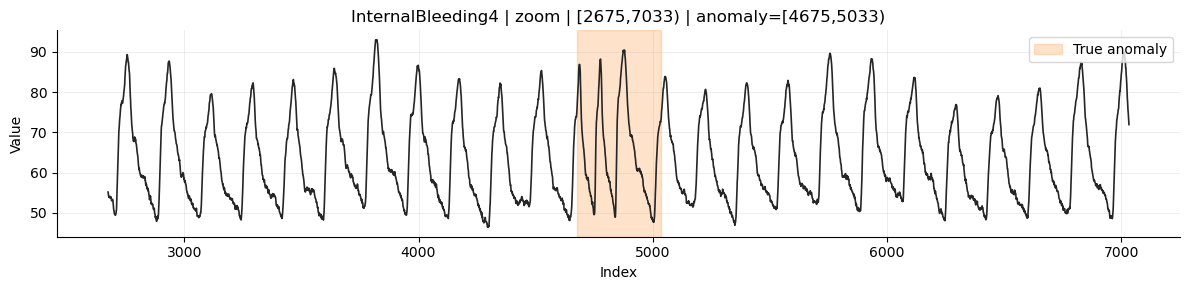

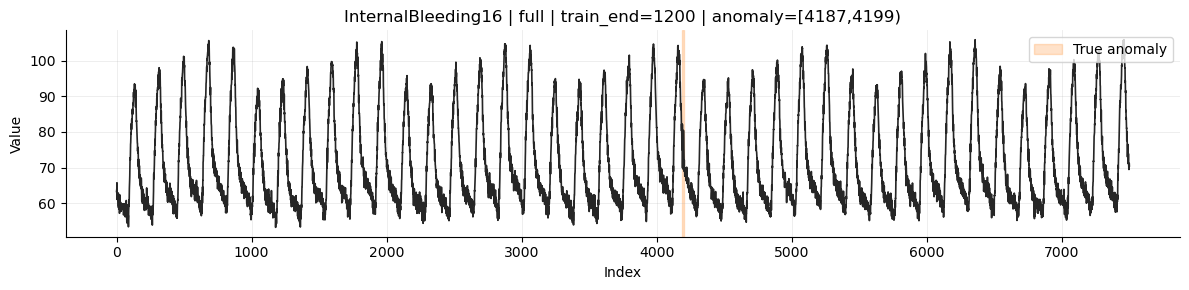

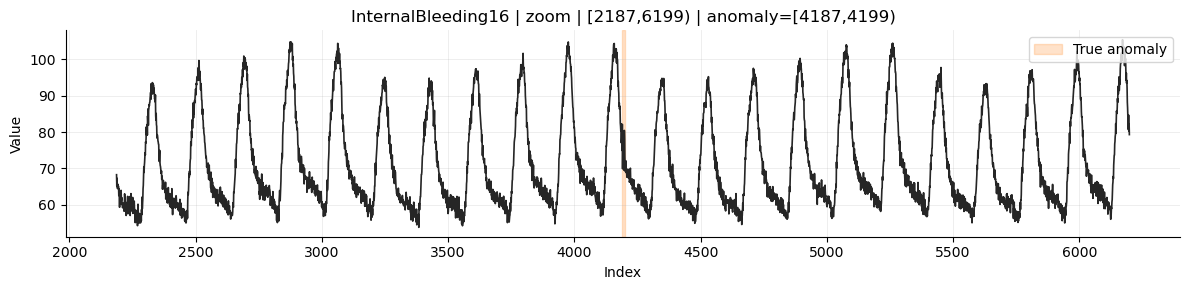

,dataset,selected_in_config,source_file,length,train_end,test_length,anomaly_start,anomaly_end,anomaly_length,anomaly_%,train_anomaly_points,test_anomaly_points,mean,std,min,max,train_windows_expected,test_windows_expected
0,InternalBleeding16,True,098_UCR_Anomaly_NOISEInternalBleeding16_1200_4...,7501,1200,6301,4187,4199,12,0.159979,0,12,71.697772,13.188082,53.200983,105.900380,269,1544
1,InternalBleeding4,True,032_UCR_Anomaly_DISTORTEDInternalBleeding4_100...,7321,1000,6321,4675,5033,358,4.890042,0,358,63.503843,11.074573,44.547412,93.029298,219,1549
2,PowerDemand1,True,152_UCR_Anomaly_PowerDemand1_9000_18485_18821.txt,29931,9000,20931,18485,18821,336,1.122582,0,336,179.477704,45.751709,77.700000,296.700000,2219,5201
3,gaitHunt2,True,171_UCR_Anomaly_gaitHunt2_18500_31200_31850.txt,64000,18500,45500,31200,31850,650,1.015625,0,650,-719.884428,874.831214,-1951.000000,405.000000,4594,11344
4,respiration1,True,186_UCR_Anomaly_respiration1_100000_110260_110...,200000,100000,100000,110260,110412,152,0.076000,0,152,-420.460607,910.133607,-1710.000000,2047.000000,24969,24969


In [3]:
# Main

base_out = results_dir("00_exploration")

save_json(
    base_out / "config_snapshot.json",
    {
        "random_seed": int(config.RANDOM_SEED),
        "window_size": int(config.WINDOW_SIZE),
        "stride": int(config.STRIDE),
        "plot_zoom_margin": int(config.PLOT_ZOOM_MARGIN),
        "datasets_selected_in_config": list(config.DATASETS),
        "pinned_raw_files": dict(config.PINNED_RAW_FILES),
        "candidates": list(CANDIDATES),
    },
)

rows = []
for name in CANDIDATES:
    series, labels, meta = load_raw_series_labels_meta(name)
    rows.append(summary_row(series, labels, meta))

    out_dir = results_dir("00_exploration", name)
    make_plots(name, series, labels, meta, out_dir)

df = pd.DataFrame(rows).sort_values(["selected_in_config", "dataset"], ascending=[False, True]).reset_index(drop=True)
display(df)

df.to_csv(base_out / "candidate_summary.csv", index=False)
save_json(base_out / "candidate_summary.json", rows)